In [1]:
# ===============================================================
#  General L-layer core (SageMath 10.7, Jupyter-friendly)
#
#  Data:
#    L >= 2
#    D = [D1, D2, ..., DL] with D1 < D2 < ... < DL
#    p1 : partition of D2 with D1 parts (list length D1, positive ints)
#    comps : compositions dict for layers 2..L-1
#            comps[I] is a list of length D[I-1] (i.e. length D_I) summing to D_{I+1}
#            Example for L=3: comps = {2: c2}
#            Example for L=4: comps = {2: c2, 3: c3}
#
#  S-sets :
#    S^{(L-1)}_{dL} = { j in [D_{L-1}] : #children(j) >= dL }
#    S^{(I)}_{d_{I+1},...,dL} = { i in [D_I] : | children(i) ∩ S^{(I+1)}_{d_{I+2},...,dL} | >= d_{I+1} }
#
#  Monomial exponent list :
#    for each d2..dL in the allowed ranges:
#      e_I = d_I - 1 for I >= 2
#      e1 runs 0..|S^{(1)}_{d2..dL}|-1
#
#  Matrix:
#    rows indexed by leaves a_L in [D_L]
#    columns indexed by exponent vectors (e1,...,eL)
#    entry = Π_{I=1..L} ( xI_{a_I(leaf)} )^{eI}
#    where a_I(leaf) is the ancestor in layer I obtained from parent maps.
#
#  Physicist sanity:
#    assert len(exps) == D_L
#    det(M), optionally factor
# ===============================================================

from sage.all import QQ, PolynomialRing, matrix, Graph, show as sage_show
from sage.all import factor, ZZ
from sage.all import SR

# -----------------------------
# helpers
# -----------------------------

def _cumsums(parts):
    s = [0]
    for x in parts:
        s.append(s[-1] + x)
    return s

def _edge_sizes(D, p1, comps):
    """
    Return dict edge_sizes[layer] for edges layer -> layer+1.
    layer=1 uses p1. layer=2..L-1 use comps[layer].
    """
    L = len(D)
    edge = {1: p1}
    for layer in range(2, L):
        if layer not in comps:
            raise ValueError(f"Missing comps[{layer}] for edge {layer}->{layer+1}.")
        edge[layer] = comps[layer]
    return edge

# -----------------------------
# (i) structure: parent + children
# -----------------------------

def build_structure_L(D, p1, comps, minimal_checks=True):
    """
    Build parent maps and children lists for general L.

    Returns:
      parent[layer]  : list of length D[layer] (=D_{layer+1}) with 1-based parent in [1..D_{layer}]
                       for layer=1..L-1
      children[layer]: list (1-based indexed via children[layer][i-1]) of children in layer+1 for i in [D_layer]
    """
    L = len(D)
    edge = _edge_sizes(D, p1, comps)

    if minimal_checks:
        # light shape checks
        if len(p1) != D[0] or sum(p1) != D[1]:
            raise ValueError("p1 must have length D1 and sum to D2.")
        for layer in range(2, L):
            comp = edge[layer]
            if len(comp) != D[layer-1] or sum(comp) != D[layer]:
                raise ValueError(f"comps[{layer}] must have length D{layer} and sum to D{layer+1}.")

    parent = {}
    children = {}

    for layer in range(1, L):
        sizes = edge[layer]                # list length D_layer, sums D_{layer+1}
        D_layer = D[layer-1]
        D_next  = D[layer]
        # parent[layer] maps nodes in layer+1 to nodes in layer
        parent_layer = [None] * D_next
        children_layer = [[] for _ in range(D_layer)]
        s = _cumsums(sizes)
        for i in range(1, D_layer + 1):
            for j in range(s[i-1] + 1, s[i] + 1):
                parent_layer[j-1] = i
                children_layer[i-1].append(j)
        parent[layer] = parent_layer
        children[layer] = children_layer

    return parent, children

def ancestor_chains_L(D, parent):
    """
    For each leaf a_L in [D_L], compute its ancestor chain (a1,...,aL).
    Returns list anc of length D_L with anc[aL-1] = (a1,...,aL).
    """
    L = len(D)
    DL = D[-1]
    anc = [None] * DL
    for leaf in range(1, DL + 1):
        chain = [None] * L
        chain[L-1] = leaf
        # walk up
        for layer in range(L-1, 0, -1):   # layer = L-1,...,1 corresponds to parent[layer]
            chain[layer-1] = parent[layer][chain[layer] - 1]
        anc[leaf - 1] = tuple(chain)
    return anc

# -----------------------------
# (ii) S-sets: recursive definition
# -----------------------------

def S_level(D, children, I, d_vec):
    """
    Compute S^{(I)}_{d_{I+1},...,d_L} as a list of nodes in [D_I].

    Inputs:
      I     : layer index (1..L-1)
      d_vec : list [d_{I+1},...,d_L] of length (L-I)
    """
    L = len(D)
    if not (1 <= I <= L-1):
        raise ValueError("I must be in 1..L-1")
    if len(d_vec) != (L - I):
        raise ValueError("d_vec must have length L-I")

    # Base: I = L-1, d_vec = [dL]
    if I == L - 1:
        dL = d_vec[0]
        out = []
        for j in range(1, D[I-1] + 1):  # nodes in layer L-1
            if len(children[I][j-1]) >= dL:
                out.append(j)
        return out

    # Recursive: compute S^{(I+1)}_{d_{I+2},...,d_L}
    d_next = d_vec[0]
    deeper = d_vec[1:]   # thresholds below I+1
    S_deeper = set(S_level(D, children, I+1, deeper))

    out = []
    for i in range(1, D[I-1] + 1):  # nodes in layer I
        kids = children[I][i-1]     # nodes in layer I+1
        # count how many children lie in S_deeper
        count = 0
        for k in kids:
            if k in S_deeper:
                count += 1
        if count >= d_next:
            out.append(i)
    return out

def S1_dvec(D, p1, comps, d_vec, structure=None):
    """
    Convenience: S^{(1)}_{d2,...,dL}.
    d_vec = [d2,...,dL].
    """
    if structure is None:
        parent, children = build_structure_L(D, p1, comps, minimal_checks=True)
    else:
        parent, children = structure
    return S_level(D, children, I=1, d_vec=d_vec)

# -----------------------------
# (iii) monomial exponent vectors
# -----------------------------

def exponent_vectors_L(D, p1, comps, structure=None, minimal_checks=True):
    """
    General-L exponent vectors (e1,...,eL) using the direct generalisation:
      for each d2..dL:
        eI = dI - 1 for I>=2
        e1 runs 0..|S^{(1)}_{d2..dL}|-1

    Returns list of tuples length L.
    """
    L = len(D)
    if L < 2:
        raise ValueError("Need L>=2")

    if structure is None:
        parent, children = build_structure_L(D, p1, comps, minimal_checks=minimal_checks)
    else:
        parent, children = structure

    edge = _edge_sizes(D, p1, comps)
    max_d = {2: max(edge[1])}   # d2 range from p1
    for I in range(3, L+1):
        max_d[I] = max(edge[I-1])

    exps = []

    # loop over all threshold tuples (d2,...,dL)
    # implemented as nested recursion for cleanliness
    def _recurse_build(I, chosen):
        """
        I is current threshold index (2..L). chosen holds [d2,...,d_{I-1}].
        """
        if I == L + 1:
            d_vec = chosen[:]  # [d2,...,dL]
            k = len(S_level(D, children, I=1, d_vec=d_vec))
            for e1 in range(k):
                e = [None] * L
                e[0] = e1
                for idx, dI in enumerate(d_vec, start=2):
                    e[idx-1] = dI - 1
                exps.append(tuple(e))
            return

        for dI in range(1, max_d[I] + 1):
            chosen.append(dI)
            _recurse_build(I+1, chosen)
            chosen.pop()

    _recurse_build(2, [])

    if minimal_checks:
        assert len(exps) == D[-1], f"Expected {D[-1]} exponent vectors, got {len(exps)}."
    return exps

def monomials_as_strings_L(exps):
    """
    Pretty-print helper: "C1^e1 * ... * CL^eL".
    """
    out = []
    L = len(exps[0]) if exps else 0
    for e in exps:
        out.append(" * ".join([f"C{i}^{e[i-1]}" for i in range(1, L+1)]))
    return out

# -----------------------------
# (iv) ring and variables
# -----------------------------

def build_ring_and_vars_L(D):
    """
    Polynomial ring with global layer variables xI_a:
      x1_1..x1_D1, x2_1..x2_D2, ..., xL_1..xL_DL
    Returns R, x_var[(I,a)].
    """
    L = len(D)
    names = []
    for I in range(1, L+1):
        for a in range(1, D[I-1] + 1):
            names.append(f"x{I}_{a}")
    R = PolynomialRing(QQ, names)
    gens = R.gens()
    name_to_var = {names[k]: gens[k] for k in range(len(names))}
    x_var = {}
    for I in range(1, L+1):
        for a in range(1, D[I-1] + 1):
            x_var[(I,a)] = name_to_var[f"x{I}_{a}"]
    return R, x_var

# -----------------------------
# (v) matrix + determinant
# -----------------------------

def monomial_matrix_L(D, p1, comps, exps=None, structure=None, minimal_checks=True):
    """
    Build DL x DL monomial evaluation matrix for general L.

    Returns: R, M, exps
    """
    if structure is None:
        parent, children = build_structure_L(D, p1, comps, minimal_checks=minimal_checks)
    else:
        parent, children = structure

    if exps is None:
        exps = exponent_vectors_L(D, p1, comps, structure=(parent, children), minimal_checks=minimal_checks)

    if minimal_checks:
        assert len(exps) == D[-1], f"Expected {D[-1]} exponent vectors, got {len(exps)}."

    anc = ancestor_chains_L(D, parent)
    R, x_var = build_ring_and_vars_L(D)

    DL = D[-1]
    M = matrix(R, DL, DL)

    for col, e in enumerate(exps):
        for leaf in range(1, DL + 1):
            chain = anc[leaf - 1]   # (a1,...,aL)
            entry = R(1)
            for I in range(1, len(D)+1):
                entry *= x_var[(I, chain[I-1])] ** e[I-1]
            M[leaf - 1, col] = entry

    return R, M, exps



def monomial_matrix_and_det_L(D, p1, comps,
                              factor_det=False,
                              normalize_diffs=False,
                              **kwargs):
    """
    Return (R, M, detM).
    If factor_det=True: detM is a factorization.
    If normalize_diffs=True (and factor_det=True): orient diff factors as (xI_a - xI_b) with a<b.
    """

    def _parse_xIa(varname):
        if not varname.startswith("x") or "_" not in varname[1:]:
            return None
        I_str, a_str = varname[1:].split("_", 1)
        return (int(I_str), int(a_str))

    def _is_two_var_linear_diff(f):
        # detect f = ±(x - y) with coeffs ±1 and no constant term
        if f.total_degree() != 1:
            return None
        d = f.dict()
        for exp in d:              # ETuple-safe
            if sum(exp) == 0:      # constant term
                return None

        terms = []
        for exp, coeff in d.items():
            if sum(exp) == 1:
                j = next(pos for pos, ej in enumerate(exp) if ej == 1)  # ETuple-safe
                terms.append((j, ZZ(coeff)))
            else:
                return None

        if len(terms) != 2:
            return None
        (j1, c1), (j2, c2) = terms
        if abs(c1) != 1 or abs(c2) != 1 or c1 != -c2:
            return None

        vars_ = f.parent().gens()
        v1, v2 = vars_[j1], vars_[j2]
        sign = 1 if c1 == 1 else -1
        return (v1, v2, sign)

    def _normalize_factorization(fac):
        # Return a SYMBOLIC product so Sage doesn't re-flip signs by refactoring
        expr = SR(fac.unit())

        for f, e in fac:
            parsed = _is_two_var_linear_diff(f)
            if parsed is None:
                expr *= SR(f)**e
                continue

            v1, v2, sign = parsed

            if sign == -1:
                expr *= (-1)**e
            base = v1 - v2

            p1p = _parse_xIa(str(v1))
            p2p = _parse_xIa(str(v2))
            if p1p is not None and p2p is not None and p1p[0] == p2p[0]:
                _, a1 = p1p
                _, a2 = p2p
                if a1 > a2:
                    expr *= (-1)**e
                    base = v2 - v1

            expr *= SR(base)**e

        return expr

    # compute matrix and determinant
    R, M, exps = monomial_matrix_L(D, p1, comps, **kwargs)
    detM = M.det()

    if factor_det:
        detM = detM.factor()
        if normalize_diffs:
            detM = _normalize_factorization(detM)

    return R, M, detM

  




# -----------------------------
# (vi) optional graph plot (general L)
# -----------------------------

def layered_graph_L(D, p1, comps, structure=None, x_spacing=3.0):
    """
    Graph with node labels aligned with determinant variables xI_a.
    Indices increase upwards.
    """
    if structure is None:
        parent, children = build_structure_L(D, p1, comps, minimal_checks=False)
    else:
        parent, children = structure

    L = len(D)
    G = Graph()

    # add vertices
    for I in range(1, L+1):
        for a in range(1, D[I-1] + 1):
            G.add_vertex(f"x{I}_{a}")

    # add edges xI_parent -> x(I+1)_child
    for I in range(1, L):
        for child in range(1, D[I] + 1):
            par = parent[I][child - 1]
            G.add_edge(f"x{I}_{par}", f"x{I+1}_{child}")

    # positions
    pos = {}
    for I in range(1, L+1):
        x = (I-1) * x_spacing
        for a in range(1, D[I-1] + 1):
            pos[f"x{I}_{a}"] = (x, a)

    return G, pos


def show_layered_graph_L(D, p1, comps, structure=None, x_spacing=2.0,
                         vertex_size=60, edge_thickness=0.5, edge_color="lightgray",
                         label_dx=0.15, label_dy=-0.15, fontsize=9,
                         axes=False, frame=False,
                         return_data=False):

    G, pos = layered_graph_L(D, p1, comps, structure=structure, x_spacing=x_spacing)

    P = G.plot(
        pos=pos,
        vertex_size=vertex_size,
        vertex_labels=False,
        edge_thickness=edge_thickness,
        edge_color=edge_color,
        axes=axes,
        frame=frame
    )

    for v in G.vertices():
        x, y = pos[v]
        P += text(
            v,
            (x + label_dx, y + label_dy),
            horizontal_alignment='left',
            vertical_alignment='top',
            fontsize=fontsize
        )

    sage_show(P)

    if return_data:
        return G, pos
        


# -----------------------------
# (vii) driver
# -----------------------------

# --- tiny aliases (direct, no out) ---

# exponent tuples
exps_L = lambda D, p1, c: exponent_vectors_L(D, p1, c)

# monomials as nice strings "C1^e1 * ... * CL^eL"
mons_L = lambda D, p1, c: monomials_as_strings_L(exponent_vectors_L(D, p1, c))

# matrix (DL x DL)
mat_L  = lambda D, p1, c: monomial_matrix_L(D, p1, c)[1]

# factored, normalized determinant
det_L  = lambda D, p1, c: monomial_matrix_and_det_L(
    D, p1, c,
    factor_det=True,
    normalize_diffs=True
)[2]

# graph (plot only; no returned clutter)
graph_L = lambda D, p1, c: show_layered_graph_L(D, p1, c)

def build_L(D, p1, comps, display=(), factor_det=False):
    """
    Physicist-friendly driver for general L.
    display can include: "graph", "monomials", "matrix", "det"
    """
    if isinstance(display, str):
        display = (display,)
    else:
        display = tuple(display)

    out = {}
    structure = build_structure_L(D, p1, comps, minimal_checks=True)
    out["structure"] = structure

    exps = exponent_vectors_L(D, p1, comps, structure=structure, minimal_checks=True)
    out["exps"] = exps

    if "monomials" in display:
        out["monomials"] = monomials_as_strings_L(exps)
        print("Monomials:")
        for m in out["monomials"]:
            print(m)

    if ("matrix" in display) or ("det" in display):
        R, M, _ = monomial_matrix_L(D, p1, comps, exps=exps, structure=structure, minimal_checks=True)
        out["R"] = R
        out["M"] = M
        if "matrix" in display:
            print("Matrix M:")
            print(M)
            
    if "det" in display:
        _, _, detM = monomial_matrix_and_det_L(
            D, p1, comps,
            factor_det=factor_det,
            normalize_diffs=True,
            exps=exps,
            structure=structure,
            minimal_checks=True
        )
        out["det"] = detM
        print("det(M):")
        print(out["det"])


    if "graph" in display:
     G, pos = show_layered_graph_L(
        D, p1, comps,
        structure=structure,
        x_spacing=2.5,
        return_data=True
    )
    out["G"] = G
    out["pos"] = pos


    return out




['C1^0 * C2^0', 'C1^1 * C2^0', 'C1^0 * C2^1', 'C1^1 * C2^1']
[        1      x1_1      x2_1 x1_1*x2_1]
[        1      x1_1      x2_2 x1_1*x2_2]
[        1      x1_2      x2_3 x1_2*x2_3]
[        1      x1_2      x2_4 x1_2*x2_4]
-(x1_1 - x1_2)^2*(x2_1 - x2_2)*(x2_3 - x2_4)


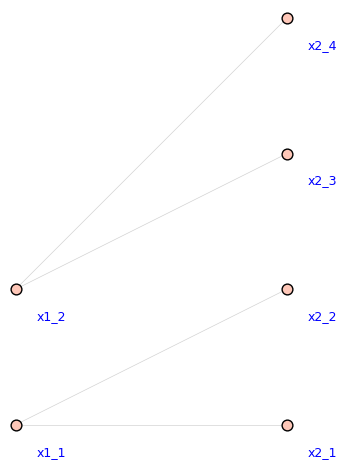

In [2]:
#L=2 example 
D = [2, 4]
p1 = [2, 2]
comps = { } # compositions empty for L=2 
#{2: [2, 1, 2, 2]}  # c2


print ( mons_L(D, p1, comps)  )   # list of monomial strings
print ( mat_L(D, p1, comps)   )    # matrix
print ( det_L(D, p1, comps) )     # factored determinant
graph_L(D, p1, comps)   # plot

Monomials:
C1^0 * C2^0
C1^1 * C2^0
C1^0 * C2^1
C1^1 * C2^1
Matrix M:
[        1      x1_1      x2_1 x1_1*x2_1]
[        1      x1_1      x2_2 x1_1*x2_2]
[        1      x1_2      x2_3 x1_2*x2_3]
[        1      x1_2      x2_4 x1_2*x2_4]
det(M):
-(x1_1 - x1_2)^2*(x2_1 - x2_2)*(x2_3 - x2_4)


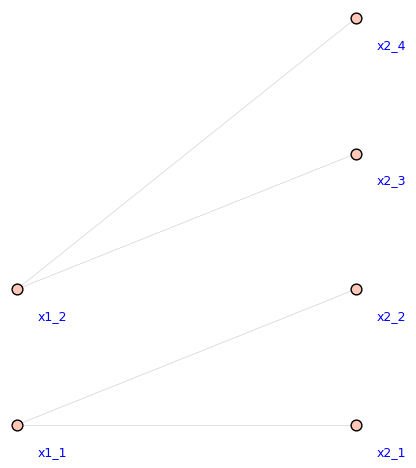

In [3]:
#L=2 example 
D = [2, 4]
p1 = [2, 2]
comps = { } # compositions empty for L=2 
#{2: [2, 1, 2, 2]}  # c2

out = build_L(D, p1, comps, display=("monomials","matrix", "det","graph"), factor_det=True)

Monomials:
C1^0 * C2^0
C1^1 * C2^0
C1^2 * C2^0
C1^3 * C2^0
C1^0 * C2^1
C1^1 * C2^1
C1^2 * C2^1
C1^3 * C2^1
C1^0 * C2^2
C1^1 * C2^2
det(M):
-(x1_1 - x1_2)^2*(x1_1 - x1_3)^2*(x1_1 - x1_4)^2*(x1_2 - x1_3)^2*(x1_2 - x1_4)^2*(x1_3 - x1_4)^3*(x2_1 - x2_2)*(x2_10 - x2_8)*(x2_10 - x2_9)*(x2_3 - x2_4)*(x2_5 - x2_6)*(x2_5 - x2_7)*(x2_6 - x2_7)*(x2_8 - x2_9)


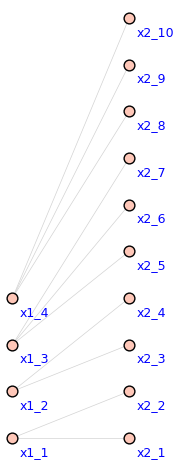

In [6]:
#L=2 example, displaying only monomials and det
D = [4,10 ]
p1 = [2, 2 , 3, 3]
comps = { } # compositions empty for L=2 
#{2: [2, 1, 2, 2]}  # c2

out = build_L(D, p1, comps, display=("monomials", "det" , "graph" ), factor_det=True)

Monomials:
C1^0 * C2^0 * C3^0
C1^1 * C2^0 * C3^0
C1^0 * C2^0 * C3^1
C1^1 * C2^0 * C3^1
C1^0 * C2^1 * C3^0
C1^1 * C2^1 * C3^0
C1^0 * C2^1 * C3^1
Matrix M:
[        1      x1_1      x3_1 x1_1*x3_1      x2_1 x1_1*x2_1 x2_1*x3_1]
[        1      x1_1      x3_2 x1_1*x3_2      x2_1 x1_1*x2_1 x2_1*x3_2]
[        1      x1_1      x3_3 x1_1*x3_3      x2_2 x1_1*x2_2 x2_2*x3_3]
[        1      x1_2      x3_4 x1_2*x3_4      x2_3 x1_2*x2_3 x2_3*x3_4]
[        1      x1_2      x3_5 x1_2*x3_5      x2_3 x1_2*x2_3 x2_3*x3_5]
[        1      x1_2      x3_6 x1_2*x3_6      x2_4 x1_2*x2_4 x2_4*x3_6]
[        1      x1_2      x3_7 x1_2*x3_7      x2_4 x1_2*x2_4 x2_4*x3_7]
det(M):
(x1_1 - x1_2)^3*(x2_1 - x2_2)*(x2_3 - x2_4)^2*(x3_1 - x3_2)*(x3_4 - x3_5)*(x3_6 - x3_7)


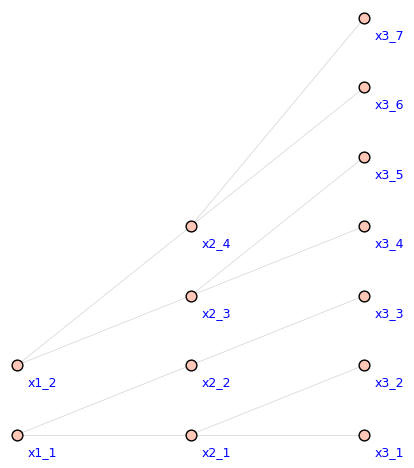

In [7]:
#L=3 example 
D = [2, 4, 7]
p1 = [2, 2]
comps = {2: [2, 1, 2, 2]}  # c2

out = build_L(D, p1, comps, display=("monomials","matrix", "det","graph"), factor_det=True)

Monomials:
C1^0 * C2^0 * C3^0 * C4^0
C1^1 * C2^0 * C3^0 * C4^0
C1^0 * C2^0 * C3^0 * C4^1
C1^1 * C2^0 * C3^0 * C4^1
C1^0 * C2^0 * C3^0 * C4^2
C1^0 * C2^0 * C3^1 * C4^0
C1^1 * C2^0 * C3^1 * C4^0
C1^0 * C2^0 * C3^1 * C4^1
C1^1 * C2^0 * C3^1 * C4^1
C1^0 * C2^1 * C3^0 * C4^0
C1^1 * C2^1 * C3^0 * C4^0
C1^0 * C2^1 * C3^1 * C4^0
Matrix M:
[              1            x1_1            x4_1       x1_1*x4_1          x4_1^2            x3_1       x1_1*x3_1       x3_1*x4_1  x1_1*x3_1*x4_1            x2_1       x1_1*x2_1       x2_1*x3_1]
[              1            x1_1            x4_2       x1_1*x4_2          x4_2^2            x3_1       x1_1*x3_1       x3_1*x4_2  x1_1*x3_1*x4_2            x2_1       x1_1*x2_1       x2_1*x3_1]
[              1            x1_1            x4_3       x1_1*x4_3          x4_3^2            x3_2       x1_1*x3_2       x3_2*x4_3  x1_1*x3_2*x4_3            x2_1       x1_1*x2_1       x2_1*x3_2]
[              1            x1_1            x4_4       x1_1*x4_4          x4_4^2     

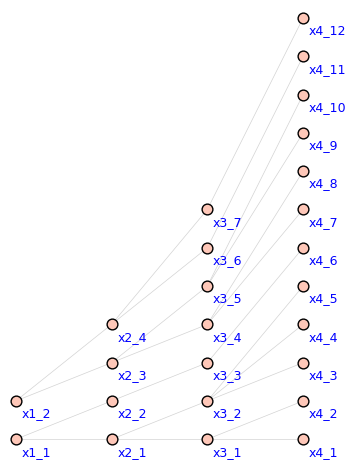

In [9]:
## L=4 example 

D = [2, 4, 7, 12 ]
p1 = [2, 2]
comps = {2: [2, 1, 2, 2] , 3: [2,3,1,2,2,1,1  ] }  # c2

out = build_L(D, p1, comps, display=("monomials","matrix", "det","graph"), factor_det=True)